In [ ]:
import jax.numpy as jnp

# Etude via le profiler

Cliquez en haut à droit du notebook pour voir le profiler intégré dans colab.

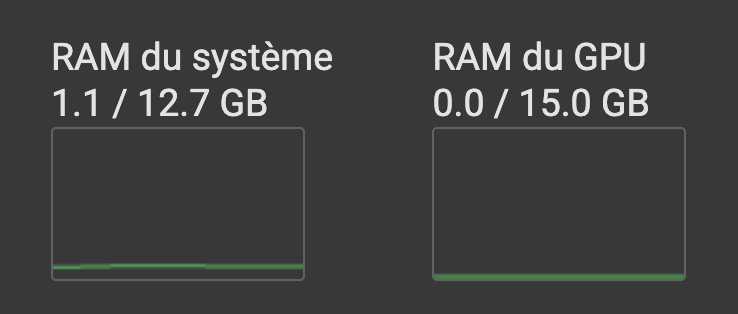

In [ ]:
size = 10_000
x = jnp.ones([1,size])

x.T @ x

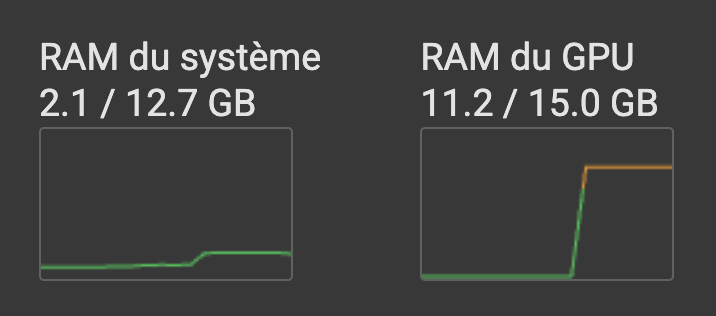

## Redémarre

In [ ]:
import jax.numpy as jnp

size = 10_000
x = jnp.ones([1,size])
x @ x.T

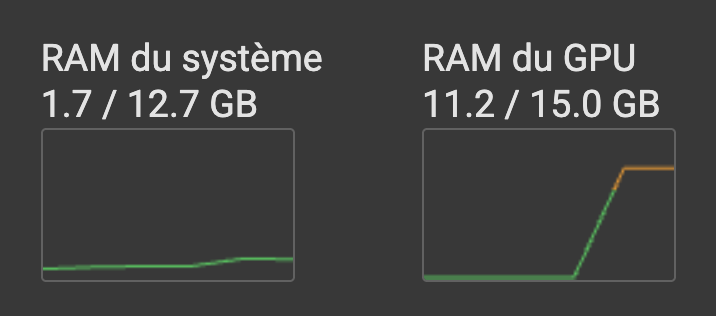

## Redémarre

In [ ]:
import jax.numpy as jnp

size = 10_000
x = jnp.ones([1,size])

def compute(x):
    return x @ x.T

compute(x)

In [ ]:
compute(x)

In [ ]:
compute(x)

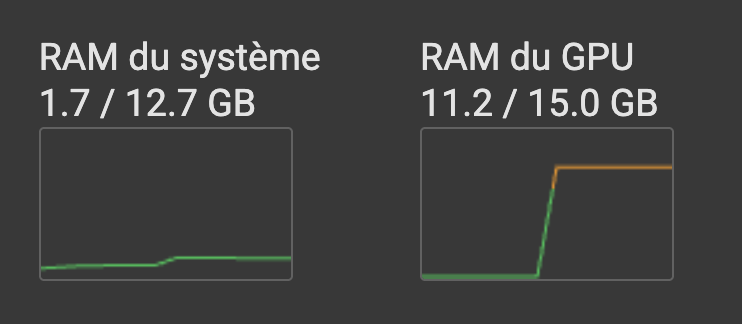

Le profile avec JAX c'est nul. Car JAX préalloue la mémoire dès le premier calcul et il ne la lache plus ensuite. Il existe de outils spécifiques, mais complexe.

# Etude via le ramase miette

***A vous:***

* Pourquoi quand vous achetez un disque dur d'1 To (1000 Go), votre système d'exploitation affiche une capacité de seulement 931 GiB (Gibioctets) ?

* Que signifie les deux lettres `gc` utilisées dans l'import ci-dessous ?

In [5]:
%reset -f

import jax
import jax.numpy as jnp
import gc

def mem():
        """
        Calcule la mémoire GPU utilisée par les JAX Arrays en mémoire.
        """
        # Force le ramasse-miettes pour un calcul plus précis
        gc.collect()

        total_bytes = 0

        # Parcourt toutes les variables pour trouver les JAX Arrays
        for obj in gc.get_objects():
            if isinstance(obj, jax.Array):
                # Le .device_buffer.nbytes est plus précis que le .nbytes
                if hasattr(obj, 'device_buffer'):
                    total_bytes += obj.device_buffer.nbytes
                else:
                    total_bytes += obj.nbytes

        # Convertit en mégaoctets
        res = total_bytes/1000**2
        print(res)
mem()

Avant l'exécution de chaque cellule ci-dessous:

Relancer la cellule ci-dessus, et térifiez à chaque fois que l'entier qui s'affiche est 0.

Attention, si une exception est lancée, l'inscruction `reset` échoue à vider la mémoire.  Donc si l'entier n'est pas 0, redémarrer la session !

In [42]:
A=jnp.ones([1000,1000])
mem()

In [44]:
A=jnp.ones([1000,1000],dtype=bool)
mem()

In [46]:
x = jnp.ones([1,1000])
mem()

In [48]:
x = jnp.ones([1,1000])
A = x.T @ x
mem()

In [50]:
x = jnp.ones([1,1000])
x.T @ x
mem()

In [52]:
x = jnp.ones([1,1000])
sca = x @ x.T
mem()

In [57]:
x = jnp.ones([1000])
pre_sca = x[None,:]* x[:,None]
sca = jnp.sum(pre_sca) #Ce n'est qu'un produit scalaire !!!
mem()

In [2]:
def many_mat_product(mat):
    interm = mat @ mat
    mem()
    return jnp.sum(interm)

mat = jnp.ones([1000,1000])
many_mat_product(mat)

In [2]:
def many_mat_product(mat):
    interm = mat @ mat
    mem()
    return jnp.sum(interm)

mat = jnp.ones([5,1000,1000])
many_mat_product(mat)

## Avec vmap

In [4]:
@jax.vmap
def many_mat_product(mat):
    interm = mat @ mat
    mem()
    return jnp.sum(interm)

mat = jnp.ones([5,1000,1000])
many_mat_product(mat)

Cela ne donne pas le même résultat. C'est normal.

***Avous:*** Modifiez la première version (sans vmap) pour optenir le même résultat qu'avec vmap.

In [7]:
def many_mat_product(mat):
    interm = mat @ mat
    mem()
    return ...

mat = jnp.ones([5,1000,1000])
many_mat_product(mat)

In [7]:
#--- To keep following outputs, do not run this cell! ---

40.0


Array([1.e+09, 1.e+09, 1.e+09, 1.e+09, 1.e+09], dtype=float32)

Ci-dessous: on fait la même chose, et c'est la KATASTROPHE... Pourquoi ?

In [2]:
@jax.vmap
def many_mat_product(mat):
    #sum_j mat_ij * mat_jk
    interm = jnp.sum(mat[:,:,None] * mat[None,:,:],axis=1)
    mem()
    return jnp.sum(interm)

mat = jnp.ones([5,1000,1000])
many_mat_product(mat)

In [2]:
@jax.vmap
def many_mat_product(mat):
    #sum_j mat_ij * mat_jk
    interm = jnp.einsum('ij,jk->ik',mat,mat)
    mem()
    return jnp.sum(interm)

mat = jnp.ones([5,1000,1000])
many_mat_product(mat)

Remarque: si on veut faire des opérations plus complexes, on est mort.

Par exemple, implémentons un produit matriciel dans l'algère max-plus (très utile pour calculer des plus cours chemin dans des graphes, et pour optimiser des indiçages de matrices creuse).  



In [4]:
@jax.vmap
def many_mat_product_max_plus(mat):
    #sum_j mat_ij * mat_jk
    interm = jnp.max(mat[:,:,None] + mat[None,:,:],axis=1)
    mem()
    return jnp.sum(interm)

mat = jnp.ones([1,1000,1000])
many_mat_product_max_plus(mat) #ça va planter ...

> @Gemini: En jax, est-que qu'il existe une fonction pour le produit matriciel max-plus ?

Il propose ceci:

    def max_plus_product(A, B):
    """Computes the max-plus matrix product of two matrices A and B."""
    # A needs to be shape (..., M, K) and B needs to be shape (..., K, N)
    # The result will be shape (..., M, N)
    # max_plus_product_ij = max_k (A_ik + B_kj)
    return lax.associative_scan(lax.max, A[:, :, None] + B[None, :, :], axis=1)


Qui plante même avec un batch_size de 1 !!!



N'hésitez pas à proposer une solution pour une meilleurs implémentation. Parlez-en au prochain TP.